<a href="https://colab.research.google.com/github/PatWalters/blog_posts/blob/main/chemfp_simsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this post, we're going to take a look at molecular similarity searches.  Molecular similarity is central to a lot of what we do in Cheminformatics.  It's important for identifying analogs and understanding SAR.  Molecular similarity is also at the core of many clustering methods that we use to understand datasets or design screening libraries.  

In this example we'll be using the [chemfp](https://chemfp.com/) package by Andrew Dalke.  Chemfp has both free and paid tiers.  With the free tier, you can perform similarity searches on smaller datasets, like the one we're using here.  For larger datasets, you need to purchase the paid version.  Chemfp is a great package. If you're using it for production drug discovery, you should buy a license.  
In addition to performing searches with chemfp, we'll also go over a few [Pandas](https://pandas.pydata.org/) tricks that will enable us to rapidly process the output from chemfp. 

## Installing software
All of the Chemistry we'll do in this notebook is performed using the [RDKit](https://www.rdkit.org/). We have to jump through a few hoops to install the RDKit on Colab, but it's not bad.  This should only take about a minute.  Btw, I would never have learned these tricks without the awesome "[Is Life Worth Living](https://iwatobipen.wordpress.com/)" blog by iwatobipen (aka Taka). 

First we download condacolab using pip.

In [ ]:
%%time
!pip install -q condacolab

CPU times: user 49.7 ms, sys: 17 ms, total: 66.7 ms
Wall time: 5.95 s


Next we install condacolab. 

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:41
🔁 Restarting kernel...


Finally we check condacolab to ensure that it works. Occasionally you may see a message saying "Your session crashed for an unknown reason".  If you see that just run the cell below again.

In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Now install the RDKit. There will be pages of output, which I've deleted here. 

In [ ]:
%%time
!mamba install -c conda-forge rdkit

Streaming output truncated to the last 5000 lines.
libpng                   [] (00m:00s) Waiting...
matplotlib-base          [] (00m:00s)      3 MB /      7 MB (  2.28 MB/s)
xorg-kbproto             [] (00m:00s) Waiting...
openssl                  [] (00m:00s)      2 MB /      2 MB (  1.35 MB/s)
libstdcxx-ng             [] (00m:01s) Decompressing...
pcre                     [] (00m:01s) Waiting...
libxcb                   [] (00m:01s) Waiting...
pixman                   [] (00m:01s) Waiting...
pyparsing                [] (00m:01s) Waiting...
libglib                  [] (00m:01s) Waiting...
libopenblas              [] (00m:01s) Waiting...
xorg-libice              [] (00m:01s) Waiting...
tornado                  [] (00m:01s) Waiting...
xorg-libxrender          [] (00m:01s) Waiting...
xorg-xextproto           [] (00m:01s) Waiting...
xorg-libx11              [] (00m:01s) Waiting...
reportlab                [] (00m:01s) Waiting...
pytz                     [] (00m:01s) Waiting...
zipp       

Let's make sure the RDKit works. 

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True 

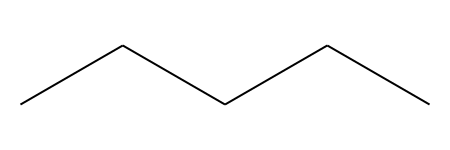

In [ ]:
mol = Chem.MolFromSmiles("CCCCC")
mol

Now we can install chemfp. 

In [ ]:
%%time
!pip install chemfp -i https://chemfp.com/packages/

Looking in indexes: https://chemfp.com/packages/
     |████████████████████████████████| 6.0 MB 2.4 MB/s 
CPU times: user 40.7 ms, sys: 11.1 ms, total: 51.8 ms
Wall time: 2.14 s


## Grabbing some data
We need some data to work with so we'll download a SMILES file with the drugs from the [ChEMBL](https://www.ebi.ac.uk/chembl/) database. 

In [ ]:
!wget https://raw.githubusercontent.com/PatWalters/datafiles/main/chembl_drugs.smi

--2021-09-04 22:02:40--  https://raw.githubusercontent.com/PatWalters/datafiles/main/chembl_drugs.smi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84820 (83K) [text/plain]
Saving to: ‘chembl_drugs.smi’

chembl_drugs.smi    100%[===================>]  82.83K  --.-KB/s    in 0.001s  

2021-09-04 22:02:40 (62.6 MB/s) - ‘chembl_drugs.smi’ saved [84820/84820]



## Performing a simple similarity search
Calculating molecular similarity with ChemFp is a two step process.  
1. Calculate the chemical fingerprints for the molecules.  This is performed using the script [**rdkit2fps**](https://chemfp.readthedocs.io/en/latest/tool-help.html#rdkit2fps). 
2. Use those fingerprints to calculate the molecular similarities. This is performed using the script [**simsearch**](https://chemfp.readthedocs.io/en/latest/tool-help.html#simsearch). 

We will start by calculating the fingerprints for the molecules in **chembl_drugs.smi**.  We are using the defaults with the Morgan fingerprints. 

In [ ]:
!rdkit2fps --morgan --output chembl_drugs.fps chembl_drugs.smi

Let's make sure the fingerprint file is there. 

In [ ]:
!ls

chembl_drugs.fps  chembl_drugs.smi  condacolab_install.log  sample_data


We will now calculate the similarity of the molecules in **chembl_drugs.smi** to the drug Imatinib (aka Gleevec).  We can get the SMILES for Imatinib from its [Wikipedia page](https://en.wikipedia.org/wiki/Imatinib). 

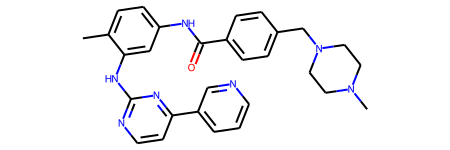

In [ ]:
imatinib_smiles = 'Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C'
imatinib_mol = Chem.MolFromSmiles(imatinib_smiles)
imatinib_mol

With the SMILES for imatinib in hand, we can do the similarity search.  We are asking **simsearch** to return the 5 most similar molecules to imatinib. 

In [ ]:
!simsearch -k 5 --query 'Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C' -o imatinib_sims.txt chembl_drugs.fps

Let's take a look at the output file from the chemfp search. The first 6 lines, which start with "#", are header lines that aren't interesting for our current efforts.  We're interested in the final line which has
- The number of similar molecule returned 
- The name of the query molecule.  We didn't provide a name, so this is just listed as "Query1". 
- Pairs of molecule name and similarity for the 5 most similar molecules. 

In [ ]:
!head -10 imatinib_sims.txt

#Simsearch/1
#num_bits=2048
#type=Tanimoto k=5 threshold=0.0
#software=chemfp/3.5.1 (base license)
#targets=chembl_drugs.fps
#target_source=chembl_drugs.smi
5	Query1	CHEMBL1642	0.94203	CHEMBL1201740	0.50549	CHEMBL2105708	0.39394	CHEMBL1421	0.27451	CHEMBL1201733	0.25510


## Parsing the similarity search output (cool Pandas tricks)

Let's take a look at how we can use Pandas to parse **imatinib_sim.txt**. 

In [ ]:
import pandas as pd

First we read the file into a dataframe.  We provide a number of argments to the **read_csv** function. 
*   skiprows - ignore the first 6 lines
*   sep - the fields are separated by tabs
*   usecols - specify the indices (starting with 0) of the columns we want to import. 
*   header - indicates that the input file doesn't have a header row. 





In [ ]:
df = pd.read_csv("imatinib_sims.txt",skiprows=6,sep="\t",usecols=range(2,12),header=None)

Here's the dataframe we just read.  We now have alternating values with the name a similar molecule and its similarity.  What we want is a table with two columns, one with the molecule name and the other with the similarity.  Let's see how we can use a bit of Pandas magic to reshape this table. 

In [ ]:
df

,2,3,4,5,6,7,8,9,10,11
0,CHEMBL1642,0.94203,CHEMBL1201740,0.50549,CHEMBL2105708,0.39394,CHEMBL1421,0.27451,CHEMBL1201733,0.2551


In order to reshape the table, we have to create a template.  This template will idicate which columns in the current table will correspond to columns in our new two column table. To do this, we will create an array with 0 in the odd numbered entries and 1 in the even numbered entries.  The function np.arange just creates an array with values from 0 to 9.  We then take the remainder "%" after dividing each of the values by 2.  

In [ ]:
import numpy as np
arr = np.arange(len(df.columns)) % 2
arr

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

We can now use the template we created above to select columns from the dataframe with the **iloc** function, which takes the rows and columns to select as arguments.  The ":" in the first argment indicates that all rows should be selected.  With those columns selected, we can use the Pandas **lreshape** method to reshape the dataframe. 

In [ ]:
name = df.iloc[:, arr == 0]
sim = df.iloc[:, arr == 1]
sim_df = pd.lreshape(df,{"Name": name, "Sim" : sim})
sim_df

,Name,Sim
0,CHEMBL1642,0.94203
1,CHEMBL1201740,0.50549
2,CHEMBL2105708,0.39394
3,CHEMBL1421,0.27451
4,CHEMBL1201733,0.25510


## Viewing similar molecules

At this point, the results are still not very useful.  We would like to be able to see the structures of the similar molecules.  Fortunately, Pandas provides a merge function that enables us to easily combine two dataframes.  We will combine the **sim_df** dataframe above with a dataframe we can generate from the input SMILES file. Note the extra arguments provided to **read_csv**.  
*   sep - tokens on each line are separated by spaces
*   names - the input file doesn't have a header row so we'll specify the column names. 




In [ ]:
drug_df = pd.read_csv("chembl_drugs.smi",sep=" ",names=["SMILES","Name"])

In [ ]:
drug_df

,SMILES,Name
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,CHEMBL700
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+],CHEMBL1200982
2,Cl.N=C(N)N,CHEMBL1200728
3,CC1=CC(=O)c2ccccc2C1=O,CHEMBL590
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,CHEMBL1370561
...,...,...
1198,Cl.Cl.N#Cc1cccc(C(NCC2CC2)c2ccc(F)c(NC(=O)c3cc...,CHEMBL4594272
1199,CN1CCC(COc2cnc(-c3cccc(Cn4nc(-c5cccc(C#N)c5)cc...,CHEMBL4594292
1200,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,CHEMBL1489
1201,COC(=O)Nc1c(N)nc(-c2nn(Cc3ccccc3F)c3ncc(F)cc23...,CHEMBL4066936


We can merge **sim_df** with **drug_df** on the common key "Name". 

In [ ]:
hit_df = sim_df.merge(drug_df,on="Name")
hit_df

,Name,Sim,SMILES
0,CHEMBL1642,0.94203,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...
1,CHEMBL1201740,0.50549,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...
2,CHEMBL2105708,0.39394,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
3,CHEMBL1421,0.27451,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...
4,CHEMBL1201733,0.25510,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...


In order to view the chemical structures for the columns in **hit_df**, we can use the excellent [mols2grid](https://github.com/cbouy/mols2grid) library.  

In [ ]:
!pip install mols2grid

     |████████████████████████████████| 133 kB 37.8 MB/s 


In [ ]:
hit_df = hit_df.round(2)

In [ ]:
import mols2grid
mols2grid.display(hit_df,subset=["img","Name","Sim"])

One of the great things about mols2grid is that we can make selections.  We can click on the checkboxes above and make selections.  The selections can then be programmatically accessed using **mols2grid.selection**. 

In [ ]:
mols2grid.selection

{0: 'CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1',
 1: 'Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)n4)c3)cc(C(F)(F)F)c2)cn1.Cl.O'}

## NxN similarity search

Another useful capability in chemfp is the NxN similarity search, where we calculate the similarity of every molecule to every other. Let's use this to create a plot of the distribution of similarities for the 5 most similar molecule to each molecule. 

Perform an NxN similarity calculation and save similarity to the 5 nearest neighbors for each drug.  We use the "-k" flag to indicate that we want to save the 5 nearest neighbors and the "-t" flag to set the threshold for neighbor similarity to 0. 

In [ ]:
!simsearch -k 5 -t 0 -o drug_sims.txt --NxN chembl_drugs.fps

Let's look at the first few lines of the output file **drug_sims.txt**. 

In [ ]:
!head -10 drug_sims.txt

#Simsearch/1
#num_bits=2048
#type=Tanimoto k=5 threshold=0.0 NxN=full
#software=chemfp/3.5.1 (base license)
#targets=chembl_drugs.fps
#target_source=chembl_drugs.smi
5	CHEMBL700	CHEMBL439	0.67647	CHEMBL443	0.51220	CHEMBL438	0.50000	CHEMBL1200359	0.50000	CHEMBL1109	0.50000
5	CHEMBL1200982	CHEMBL971	0.76471	CHEMBL1200903	0.54762	CHEMBL1200802	0.42500	CHEMBL448	0.42105	CHEMBL1200790	0.25581
5	CHEMBL1200728	CHEMBL1703	0.31579	CHEMBL2096648	0.30000	CHEMBL467	0.21429	CHEMBL1200494	0.19355	CHEMBL1398126	0.18750
5	CHEMBL590	CHEMBL711	0.29032	CHEMBL712	0.27027	CHEMBL1550	0.26000	CHEMBL1256391	0.25000	CHEMBL1450	0.25000


The format is 6 header lines followed by one row for each molecule in the input file 
- The number of similarity values **N**
- The name of the reference molecule
- Subsequent entires are **N** pairs with
    - The name of the similar molecule
    - The similarity to the similar molecule
    
Let's say that we want to generate a plot of the distribution for the top 5 similar molecules to each molecule in the set.  This is a snap with Pandas.  Our workflow will be:
1. Read the ChemFp output 
2. Generate list of the columns that contains floating point values
3. Create a new dataframe with only the floating point columns
4. "Melt" the new dataframe into a single column

## Parsing the NxN similarity search output (more cool Pandas tricks)

Read the output file from the NxN similarity search. 

In [ ]:
nxn_df = pd.read_csv("drug_sims.txt",skiprows=6,sep="\t",header=None)

Note a couple of things about the dataframe below. 
1. We didn't have column names so each column is given a number as a name
2. There are 5 floating point columns

In [ ]:
nxn_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,5,CHEMBL700,CHEMBL439,0.67647,CHEMBL443,0.51220,CHEMBL438,0.50000,CHEMBL1200359,0.50000,CHEMBL1109,0.50000
1,5,CHEMBL1200982,CHEMBL971,0.76471,CHEMBL1200903,0.54762,CHEMBL1200802,0.42500,CHEMBL448,0.42105,CHEMBL1200790,0.25581
2,5,CHEMBL1200728,CHEMBL1703,0.31579,CHEMBL2096648,0.30000,CHEMBL467,0.21429,CHEMBL1200494,0.19355,CHEMBL1398126,0.18750
3,5,CHEMBL590,CHEMBL711,0.29032,CHEMBL712,0.27027,CHEMBL1550,0.26000,CHEMBL1256391,0.25000,CHEMBL1450,0.25000
4,5,CHEMBL1370561,CHEMBL1200578,0.74359,CHEMBL190,0.46154,CHEMBL113,0.40000,CHEMBL1752,0.34000,CHEMBL1200434,0.33333


Next we crate a list that indicates whether a particular column contains a floating point value. We cast this to a list to make it easier to deal with.

In [ ]:
is_float = list(df.dtypes == float)
is_float

[False, True, False, True, False, True, False, True, False, True]

We use the **loc** function to specify the rows and columns that we want to select from the dataframe.  The **":"** specifies that we want all rows. 

In [ ]:
df_filtered = df.loc[:,is_float]
df_filtered.head()

,3,5,7,9,11
0,0.94203,0.50549,0.39394,0.27451,0.2551


We can use the Pandas **melt** function to collapase the dataframe to a single column. In **df_melt**, the **variable** column contains the column name from **df_filered** and the **value** column contains the corresponding value. 

In [ ]:
df_melt = df_filtered.melt()
df_melt.head()

,variable,value
0,3,0.94203
1,5,0.50549
2,7,0.39394
3,9,0.27451
4,11,0.25510


We only want to the **value** column so we'll convert that to a numpy array. 

In [ ]:
sim_array = df_filtered.melt().value.to_numpy()
sim_array

array([0.94203, 0.50549, 0.39394, 0.27451, 0.2551 ])

The explanation above is kind of long, but the whole operation can be written in 3 line of code. 

In [ ]:
nxn_df = pd.read_csv("drug_sims.txt",skiprows=6,sep="\t",header=None)
df_filtered = nxn_df.loc[:,list(nxn_df.dtypes == float)]
sim_array = df_filtered.melt().value.to_numpy()

Now that we have the similarity values, we can plot a kernel density estimate

In [ ]:
import seaborn as sns

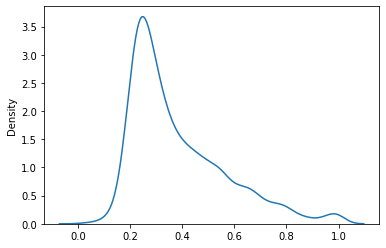

In [ ]:
sns.kdeplot(sim_array);

## Aggregating data with Pandas groupby (even more Pandas tricks)

Let's try a related task and calculate the mean similarity for the top 5 neighbors of each drug molecule. First, recall what our dataframe looks like. 

In [ ]:
nxn_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,5,CHEMBL700,CHEMBL439,0.67647,CHEMBL443,0.51220,CHEMBL438,0.50000,CHEMBL1200359,0.50000,CHEMBL1109,0.50000
1,5,CHEMBL1200982,CHEMBL971,0.76471,CHEMBL1200903,0.54762,CHEMBL1200802,0.42500,CHEMBL448,0.42105,CHEMBL1200790,0.25581
2,5,CHEMBL1200728,CHEMBL1703,0.31579,CHEMBL2096648,0.30000,CHEMBL467,0.21429,CHEMBL1200494,0.19355,CHEMBL1398126,0.18750
3,5,CHEMBL590,CHEMBL711,0.29032,CHEMBL712,0.27027,CHEMBL1550,0.26000,CHEMBL1256391,0.25000,CHEMBL1450,0.25000
4,5,CHEMBL1370561,CHEMBL1200578,0.74359,CHEMBL190,0.46154,CHEMBL113,0.40000,CHEMBL1752,0.34000,CHEMBL1200434,0.33333


In this case we want column 1, which has the molecule name as well as columns 3,5,7,9, and 11, which have the similariy values. We can modify the approach we used above to select the columns we want. 

In [ ]:
is_useful = list(nxn_df.dtypes == float)
is_useful[1] = True
is_useful

[False, True, False, True, False, True, False, True, False, True, False, True]

Again, we can use **loc** to create a new dataframe with the columns we want. Since we'll be manipulating the dataframe, we'll add the **copy** function to create a new copy of the resulting dataframe. 

In [ ]:
nbr_df = nxn_df.loc[:,is_useful].copy()
nbr_df.columns = ["Name"] + [f"SIM_{x:02d}" for x in range(1,6)]
nbr_df

,Name,SIM_01,SIM_02,SIM_03,SIM_04,SIM_05
0,CHEMBL700,0.67647,0.51220,0.50000,0.50000,0.50000
1,CHEMBL1200982,0.76471,0.54762,0.42500,0.42105,0.25581
2,CHEMBL1200728,0.31579,0.30000,0.21429,0.19355,0.18750
3,CHEMBL590,0.29032,0.27027,0.26000,0.25000,0.25000
4,CHEMBL1370561,0.74359,0.46154,0.40000,0.34000,0.33333
...,...,...,...,...,...,...
1198,CHEMBL4594272,0.23469,0.23009,0.20952,0.20000,0.19828
1199,CHEMBL4594292,0.25843,0.24742,0.24490,0.23009,0.22018
1200,CHEMBL1489,0.61702,0.48000,0.40323,0.35000,0.34545
1201,CHEMBL4066936,0.56757,0.25641,0.23171,0.22115,0.22105


As above, we'll **melt** the dataframe, but this time we'll specify that we want the new melted dataframe organized by **Name**. 

In [ ]:
melt_nbr_df = nbr_df.melt(id_vars="Name")
melt_nbr_df.sort_values("variable")

,Name,variable,value
0,CHEMBL700,SIM_01,0.67647
806,CHEMBL591665,SIM_01,0.65625
805,CHEMBL196,SIM_01,0.65625
804,CHEMBL848,SIM_01,0.61702
803,CHEMBL1201192,SIM_01,1.00000
...,...,...,...
5209,CHEMBL786,SIM_05,0.42188
5208,CHEMBL2062335,SIM_05,0.54237
5207,CHEMBL1200503,SIM_05,0.20149
5205,CHEMBL479,SIM_05,0.39655


Now we calculate the mean similarity for each of the molecules in one line of code with a call to the groupby method.  This operation will group the similarity values by molecule name and calculate the mean of the similarity values. One record from the groupby operation looks like this. 

In [ ]:
[x for x in melt_nbr_df.groupby("Name")][0]

('CHEMBL1003',             Name variable    value
 923   CHEMBL1003   SIM_01  0.20896
 2126  CHEMBL1003   SIM_02  0.20000
 3329  CHEMBL1003   SIM_03  0.20000
 4532  CHEMBL1003   SIM_04  0.19355
 5735  CHEMBL1003   SIM_05  0.19298)

In [ ]:
sim_mean_df = melt_nbr_df.groupby("Name").mean().reset_index()
sim_mean_df.head()

,Name,value
0,CHEMBL1003,0.199098
1,CHEMBL1009,0.496374
2,CHEMBL101,0.458004
3,CHEMBL1014,0.313364
4,CHEMBL1017,0.282826


Let's make the column names more meaningful.

In [ ]:
sim_mean_df.columns = ["Name","Mean_Similarity"]

We can sort by **Mean_Similarity"** to find find the molecules with the most similar neighbors

In [ ]:
sim_mean_df.sort_values("Mean_Similarity",ascending=False,inplace=True)
sim_mean_df

,Name,Mean_Similarity
1033,CHEMBL532,0.812930
147,CHEMBL1200544,0.788550
98,CHEMBL1200366,0.778240
1073,CHEMBL612,0.775428
940,CHEMBL405,0.775428
...,...,...
195,CHEMBL1200718,0.118558
152,CHEMBL1200572,0.118444
667,CHEMBL2096633,0.111428
249,CHEMBL1200866,0.101360


Again, this isn't very meaningful if we can't look at chemical structures.  We'll merge **sim_mean_df** with the information in the original SMILES file so that we can look at structures.  

In [ ]:
combo_df = sim_mean_df.merge(drug_df, on="Name")
combo_df

,Name,Mean_Similarity,SMILES
0,CHEMBL532,0.812930,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...
1,CHEMBL1200544,0.788550,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccc...
2,CHEMBL1200366,0.778240,CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccc...
3,CHEMBL612,0.775428,C[C@H](N)Cc1ccccc1
4,CHEMBL405,0.775428,CC(N)Cc1ccccc1
...,...,...,...
1198,CHEMBL1200718,0.118558,[Mg+2].[OH-].[OH-]
1199,CHEMBL1200572,0.118444,O=[Mg]
1200,CHEMBL2096633,0.111428,O=[Si]([O-])O[Si]([O-])([O-])O[Si](=O)[O-].[Mg...
1201,CHEMBL1200866,0.101360,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...


Let's create a new dataframe with the 20 molecules with the highest similarity among the 5 nearest neighbors.

In [ ]:
top_df = combo_df.sort_values("Mean_Similarity",ascending=False).head(20).copy()

In order to make the data easier to look at, we'll round the similarity values to 2 decimal places. 

As above, we can use mols2grid to look at the top20 molecules.  It's interesting to note that many of our top 20 are duplicates. Note that [ampetamine](https://en.wikipedia.org/wiki/Amphetamine) is here 4 times, as an enantiomer (dextroamphetamine), a racemate, and two different salt forms.  

In [ ]:
mols2grid.display(top_df,subset=["img","Name","Mean_Similarity"])